<a href="https://colab.research.google.com/github/yung540825/NVIDIA_corp_prediction/blob/main/NVIDIA_corp_prediction(DNN%E7%89%88%E6%9C%AC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1523]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from tensorflow.keras import backend as clear
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Note: Some metrics need to be defined manually

In [1524]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [1525]:
#讀取csv，由於2018/01/01休市，故資料從2018/01/02開始
df = pd.read_csv('/content/NVDA (5).csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,48.945000,49.875000,48.625000,49.837502,49.326294,35561600
1,2018-01-03,51.025002,53.424999,50.937500,53.117500,52.572651,91470400
2,2018-01-04,53.939999,54.512501,53.172501,53.397499,52.849770,58326800
3,2018-01-05,53.547501,54.227501,52.770000,53.849998,53.297626,58012400
4,2018-01-08,55.099998,56.250000,54.645000,55.500000,54.930702,88121600
...,...,...,...,...,...,...,...
750,2020-12-23,132.559998,132.750000,130.050003,130.092499,129.835495,17914400
751,2020-12-24,130.372498,131.324997,129.387497,129.937500,129.680801,9788400
752,2020-12-28,130.625000,130.625000,127.632500,129.000000,128.745132,21256400
753,2020-12-29,129.250000,130.725006,128.422501,129.432495,129.176773,17037200


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [1526]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       755 non-null    object 
 1   Open       755 non-null    float64
 2   High       755 non-null    float64
 3   Low        755 non-null    float64
 4   Close      755 non-null    float64
 5   Adj Close  755 non-null    float64
 6   Volume     755 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 41.4+ KB


In [1527]:
#建立新的DataFrame，包含日期和Adjusted Close(調整後收盤價)
new_df=df.iloc[:,[0,5]].copy()
new_df.head()

,Date,Adj Close
0,2018-01-02,49.326294
1,2018-01-03,52.572651
2,2018-01-04,52.849770
3,2018-01-05,53.297626
4,2018-01-08,54.930702


In [1528]:
#看Adjusted Close的敘述統計
new_df.describe()

,Adj Close
count,755.000000
mean,66.511904
std,29.545626
min,31.531858
25%,44.769205
50%,59.671272
75%,70.402127
max,145.289398


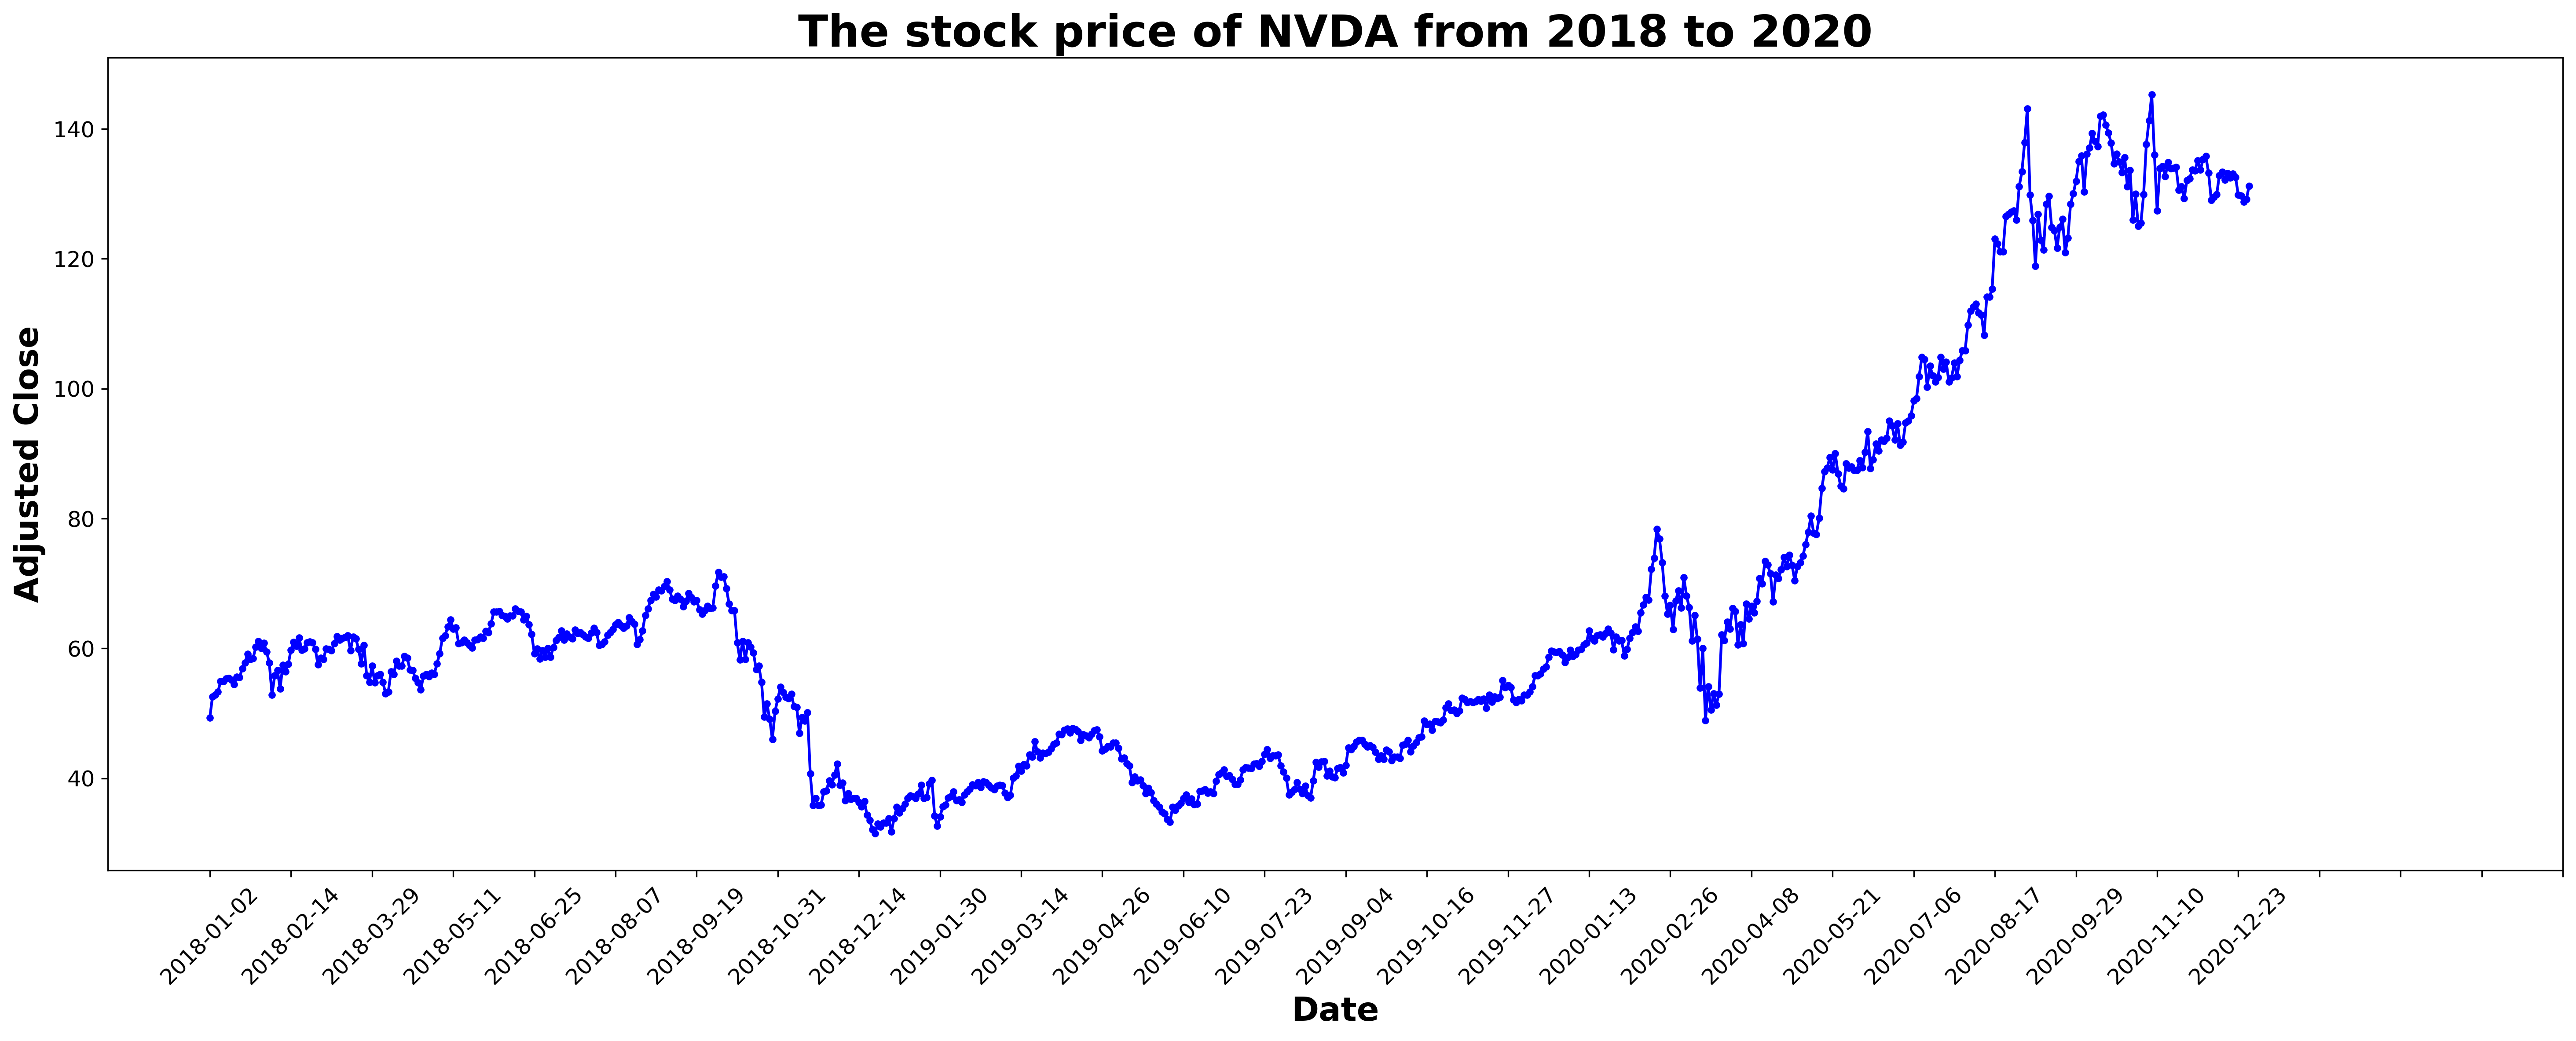

In [1529]:
#畫出2020至2022間NVDA的股價
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('The stock price of NVDA from 2018 to 2020',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Adjusted Close',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Adj Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 900, step=30))
plt.show()

# 2. Creating time lags as predictor variables

In [1530]:
#創建3個lags
new_df['Lag_1']=new_df['Adj Close'].shift(1).copy()#把資料往下移1格作為lag1
new_df['Lag_2']=new_df['Adj Close'].shift(2).copy()#把資料往下移1格作為lag2
new_df['Lag_3']=new_df['Adj Close'].shift(3).copy()#把資料往下移1格作為lag3
new_df.head()

,Date,Adj Close,Lag_1,Lag_2,Lag_3
0,2018-01-02,49.326294,NaN,NaN,NaN
1,2018-01-03,52.572651,49.326294,NaN,NaN
2,2018-01-04,52.849770,52.572651,49.326294,NaN
3,2018-01-05,53.297626,52.849770,52.572651,49.326294
4,2018-01-08,54.930702,53.297626,52.849770,52.572651


In [1531]:
# 去除掉具NaN值的列
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Adj Close,Lag_1,Lag_2,Lag_3
0,2018-01-05,53.297626,52.849770,52.572651,49.326294
1,2018-01-08,54.930702,53.297626,52.849770,52.572651
2,2018-01-09,54.915863,54.930702,53.297626,52.849770
3,2018-01-10,55.346397,54.915863,54.930702,53.297626
4,2018-01-11,55.445370,55.346397,54.915863,54.930702
...,...,...,...,...,...
747,2020-12-23,129.835495,132.520203,133.059113,132.457809
748,2020-12-24,129.680801,129.835495,132.520203,133.059113
749,2020-12-28,128.745132,129.680801,129.835495,132.520203
750,2020-12-29,129.176773,128.745132,129.680801,129.835495


# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [1532]:
#2018到2020的資料作為訓練集
Forecast_train_data=clean_df.iloc[0:450,:].copy()
Forecast_train_data

,Date,Adj Close,Lag_1,Lag_2,Lag_3
0,2018-01-05,53.297626,52.849770,52.572651,49.326294
1,2018-01-08,54.930702,53.297626,52.849770,52.572651
2,2018-01-09,54.915863,54.930702,53.297626,52.849770
3,2018-01-10,55.346397,54.915863,54.930702,53.297626
4,2018-01-11,55.445370,55.346397,54.915863,54.930702
...,...,...,...,...,...
445,2019-10-14,46.429451,46.295029,45.558258,44.980789
446,2019-10-15,48.878735,46.429451,46.295029,45.558258
447,2019-10-16,48.341091,48.878735,46.429451,46.295029
448,2019-10-17,48.360992,48.341091,48.878735,46.429451


In [1533]:
#2022年作為測試集(假日和特殊節日休市，故2022年下半年只有148筆)
Forecast_test_data=clean_df.iloc[450:450+348,:].copy()
Forecast_test_data

,Date,Adj Close,Lag_1,Lag_2,Lag_3
450,2019-10-21,48.789135,47.415138,48.360992,48.341091
451,2019-10-22,48.689564,48.789135,47.415138,48.360992
452,2019-10-23,48.560135,48.689564,48.789135,47.415138
453,2019-10-24,49.000694,48.560135,48.689564,48.789135
454,2019-10-25,50.912342,49.000694,48.560135,48.689564
...,...,...,...,...,...
747,2020-12-23,129.835495,132.520203,133.059113,132.457809
748,2020-12-24,129.680801,129.835495,132.520203,133.059113
749,2020-12-28,128.745132,129.680801,129.835495,132.520203
750,2020-12-29,129.176773,128.745132,129.680801,129.835495


# 4. Prepare time-series data for train/validation structure manually

# Expanding window

In [1534]:
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:360,:].copy()
Exp_val_1=Forecast_train_data.iloc[360:360+30,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:390,:].copy()
Exp_val_2=Forecast_train_data.iloc[390:390+30,:].copy()

# Expanding 3:
Exp_training_3=Forecast_train_data.iloc[0:420,:].copy()
Exp_val_3=Forecast_train_data.iloc[420:420+30,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [1535]:
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Adj Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Adj Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Adj Close'].copy()
y_val=Exp_val_3['Adj Close'].copy()

# 6. Creating Net 

In [1536]:
# Quick recap: 有3個feature在data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.530374,0.523479,0.442712
1,0.541516,0.530374,0.523479
2,0.582146,0.541516,0.530374
3,0.581777,0.582146,0.541516
4,0.592488,0.581777,0.582146


In [1537]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [1538]:
import keras.backend as K
from keras.losses import mse
from keras.utils import get_custom_objects

def my_RMSE(y_true, y_pred):
    return K.sqrt(mse(y_true, y_pred))

get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [1539]:
# Some self define functions for building deep neural networks
def dense_generator(model_name,layers,last_layer_neurons,activation_fun='linear'):
    n=last_layer_neurons
    neurons=n
    for i in range(0,layers):
        neurons=neurons*2
        model_name.add(Dense(units=neurons, activation=activation_fun))

In [1540]:
# Create the model
clear.clear_session()
model=Sequential()

# Add input layer(有3個feature，所以input_dim=3) & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# Add 2 dense layers
dense_generator(model,3,2)

# Add dropout layer
model.add(Dropout(rate=0.3))

# Add 2 dense layers
dense_generator(model,3,2)

# regularization layer optional
model.add(BatchNormalization())

# Add 2 dense layers
dense_generator(model,3,2)

# Add dropout layer
model.add(Dropout(rate=0.3))

# Add output layer
model.add(Dense(units=1, activation='linear'))

# Compile the defined Net 改
opt=Adam(learning_rate=0.0008,beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 4)                 28        
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
 dense_5 (Dense)             (None, 8)                 4

Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [1541]:

# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
7/7 [==============================] - 4s 50ms/step - loss: 50.4539 - mean_absolute_percentage_error: 100.0694 - val_loss: 44.9767 - val_mean_absolute_percentage_error: 99.6966
Epoch 2/300
7/7 [==============================] - 0s 9ms/step - loss: 50.4539 - mean_absolute_percentage_error: 100.0337 - val_loss: 44.8995 - val_mean_absolute_percentage_error: 99.5249
Epoch 3/300
7/7 [==============================] - 0s 10ms/step - loss: 50.3386 - mean_absolute_percentage_error: 99.7622 - val_loss: 44.8088 - val_mean_absolute_percentage_error: 99.3235
Epoch 4/300
7/7 [==============================] - 0s 10ms/step - loss: 50.2425 - mean_absolute_percentage_error: 99.4923 - val_loss: 44.6995 - val_mean_absolute_percentage_error: 99.0807
Epoch 5/300
7/7 [==============================] - 0s 9ms/step - loss: 50.0170 - mean_absolute_percentage_error: 99.1011 - val_loss: 44.5762 - val_mean_absolute_percentage_error: 98.8071
Epoch 6/300
7/7 [==============================] - 0s 12ms/s

In [1542]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

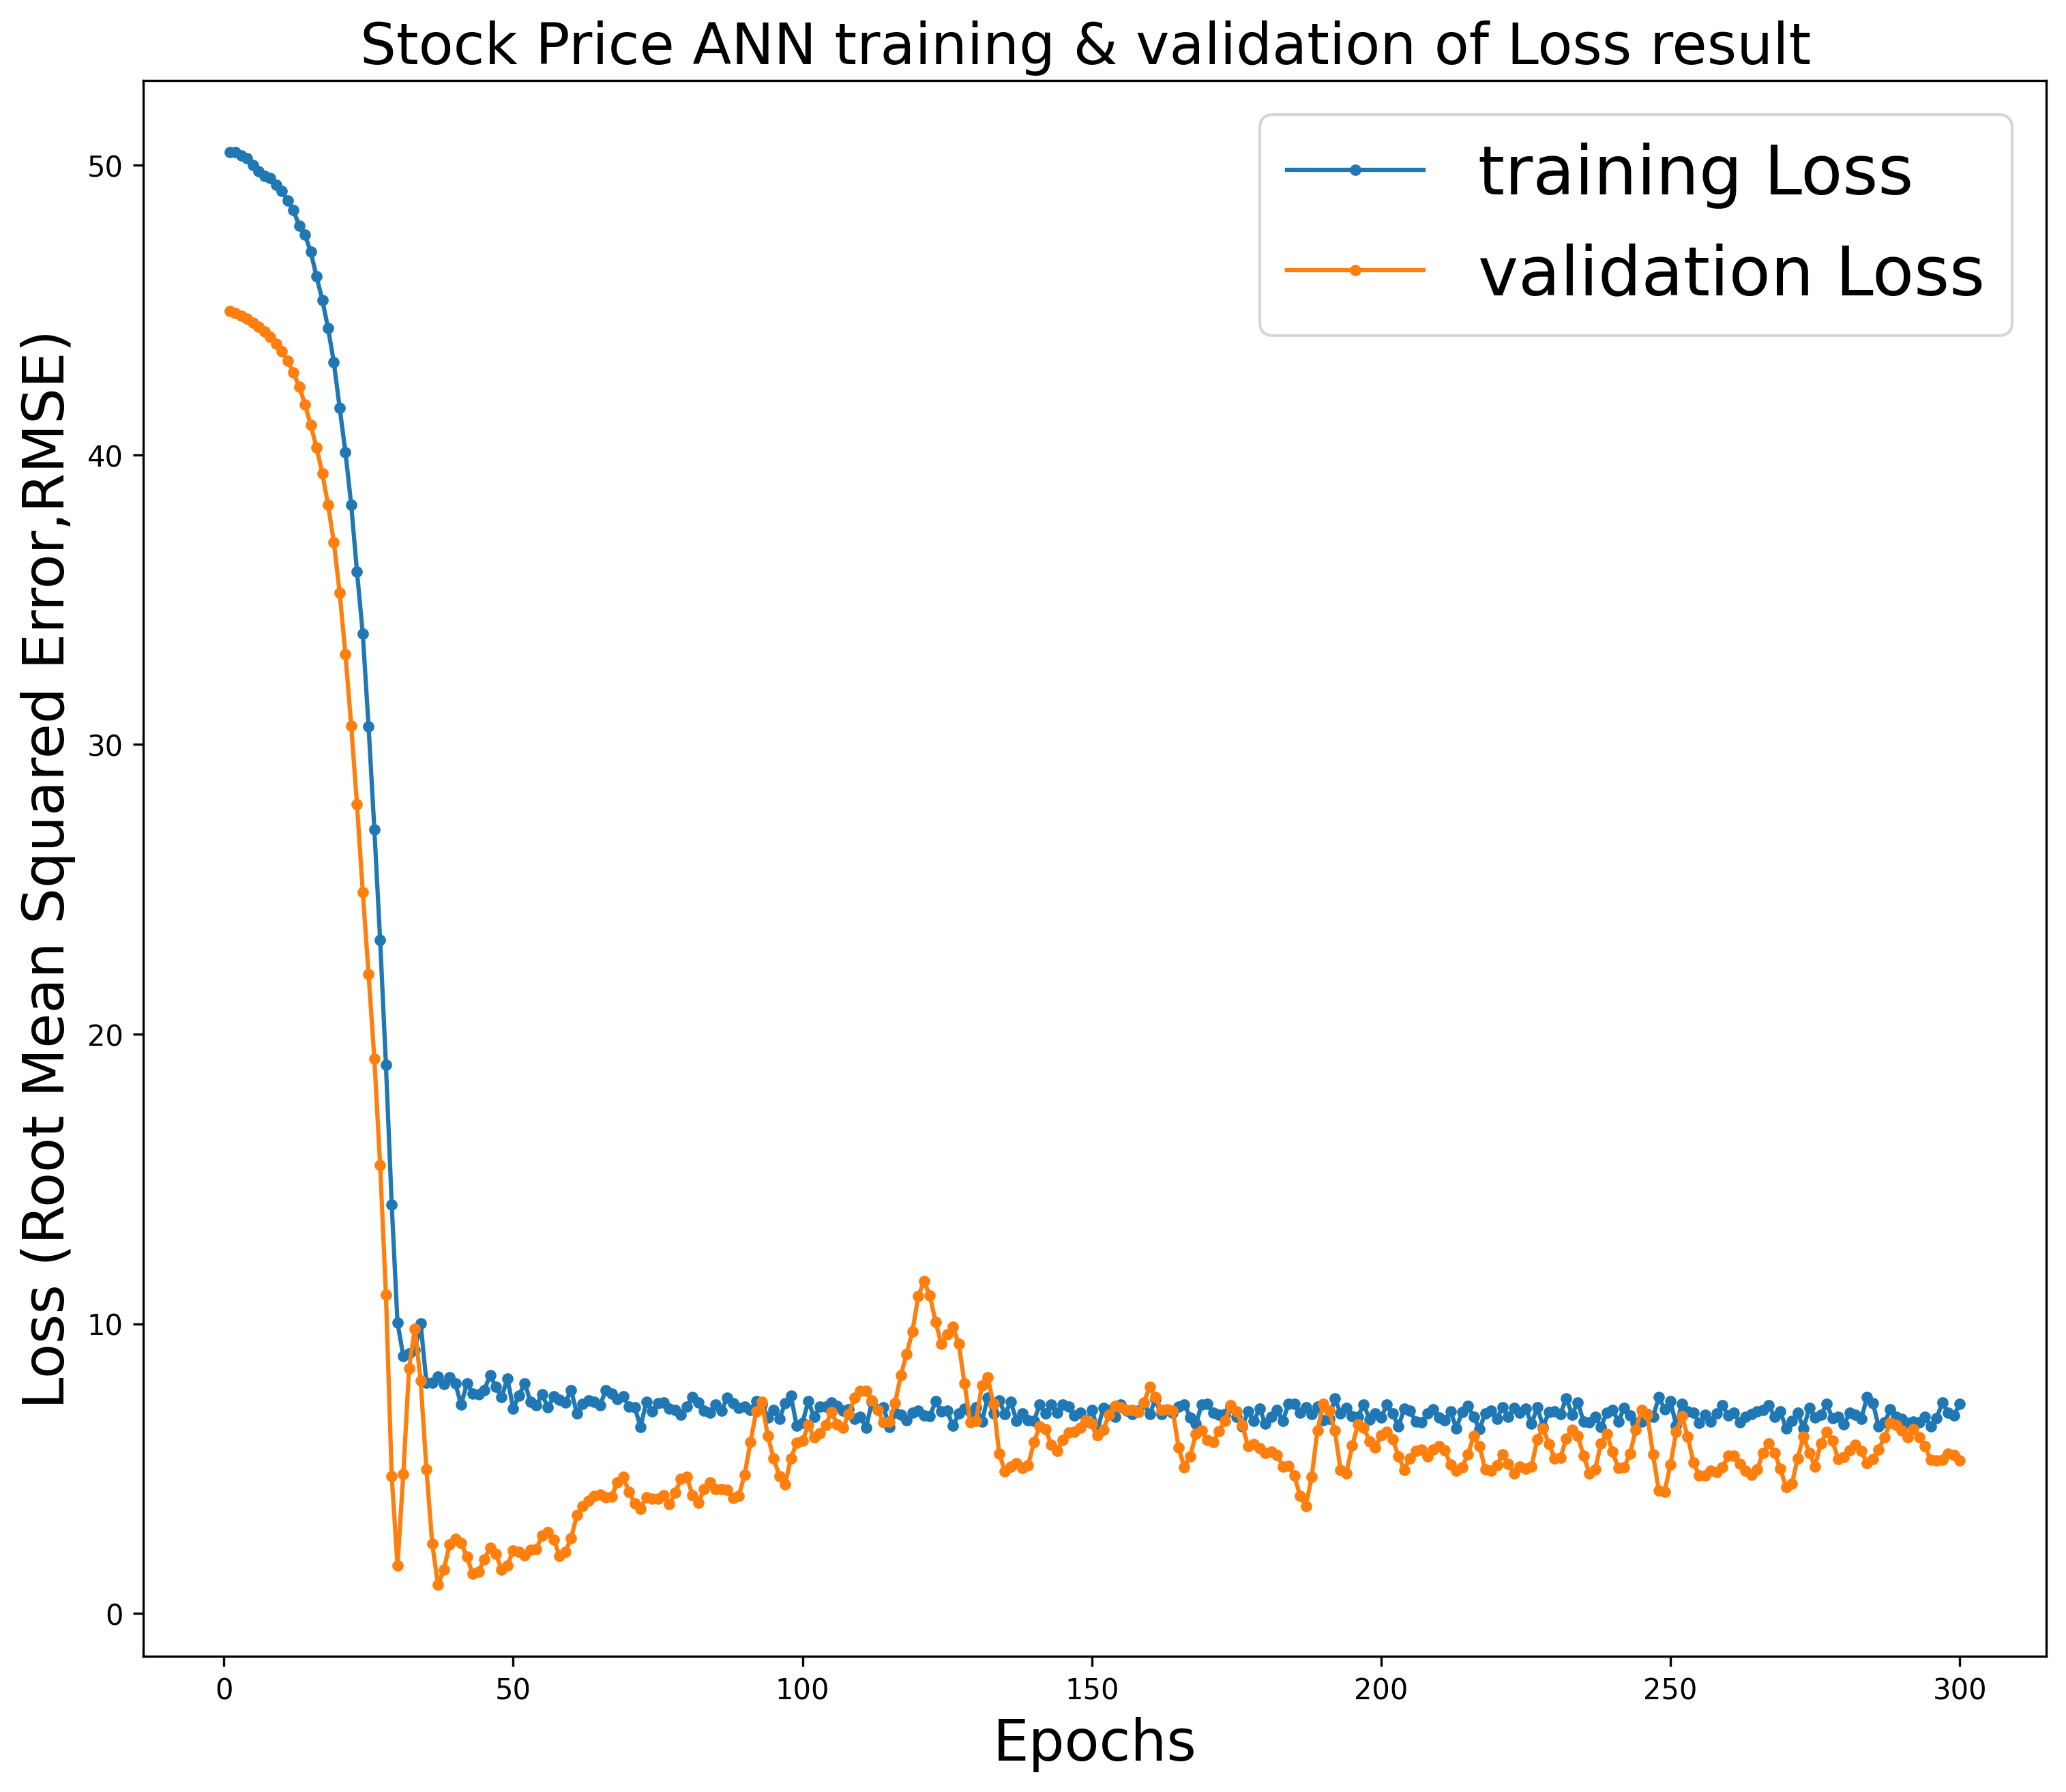

In [1543]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Stock Price ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

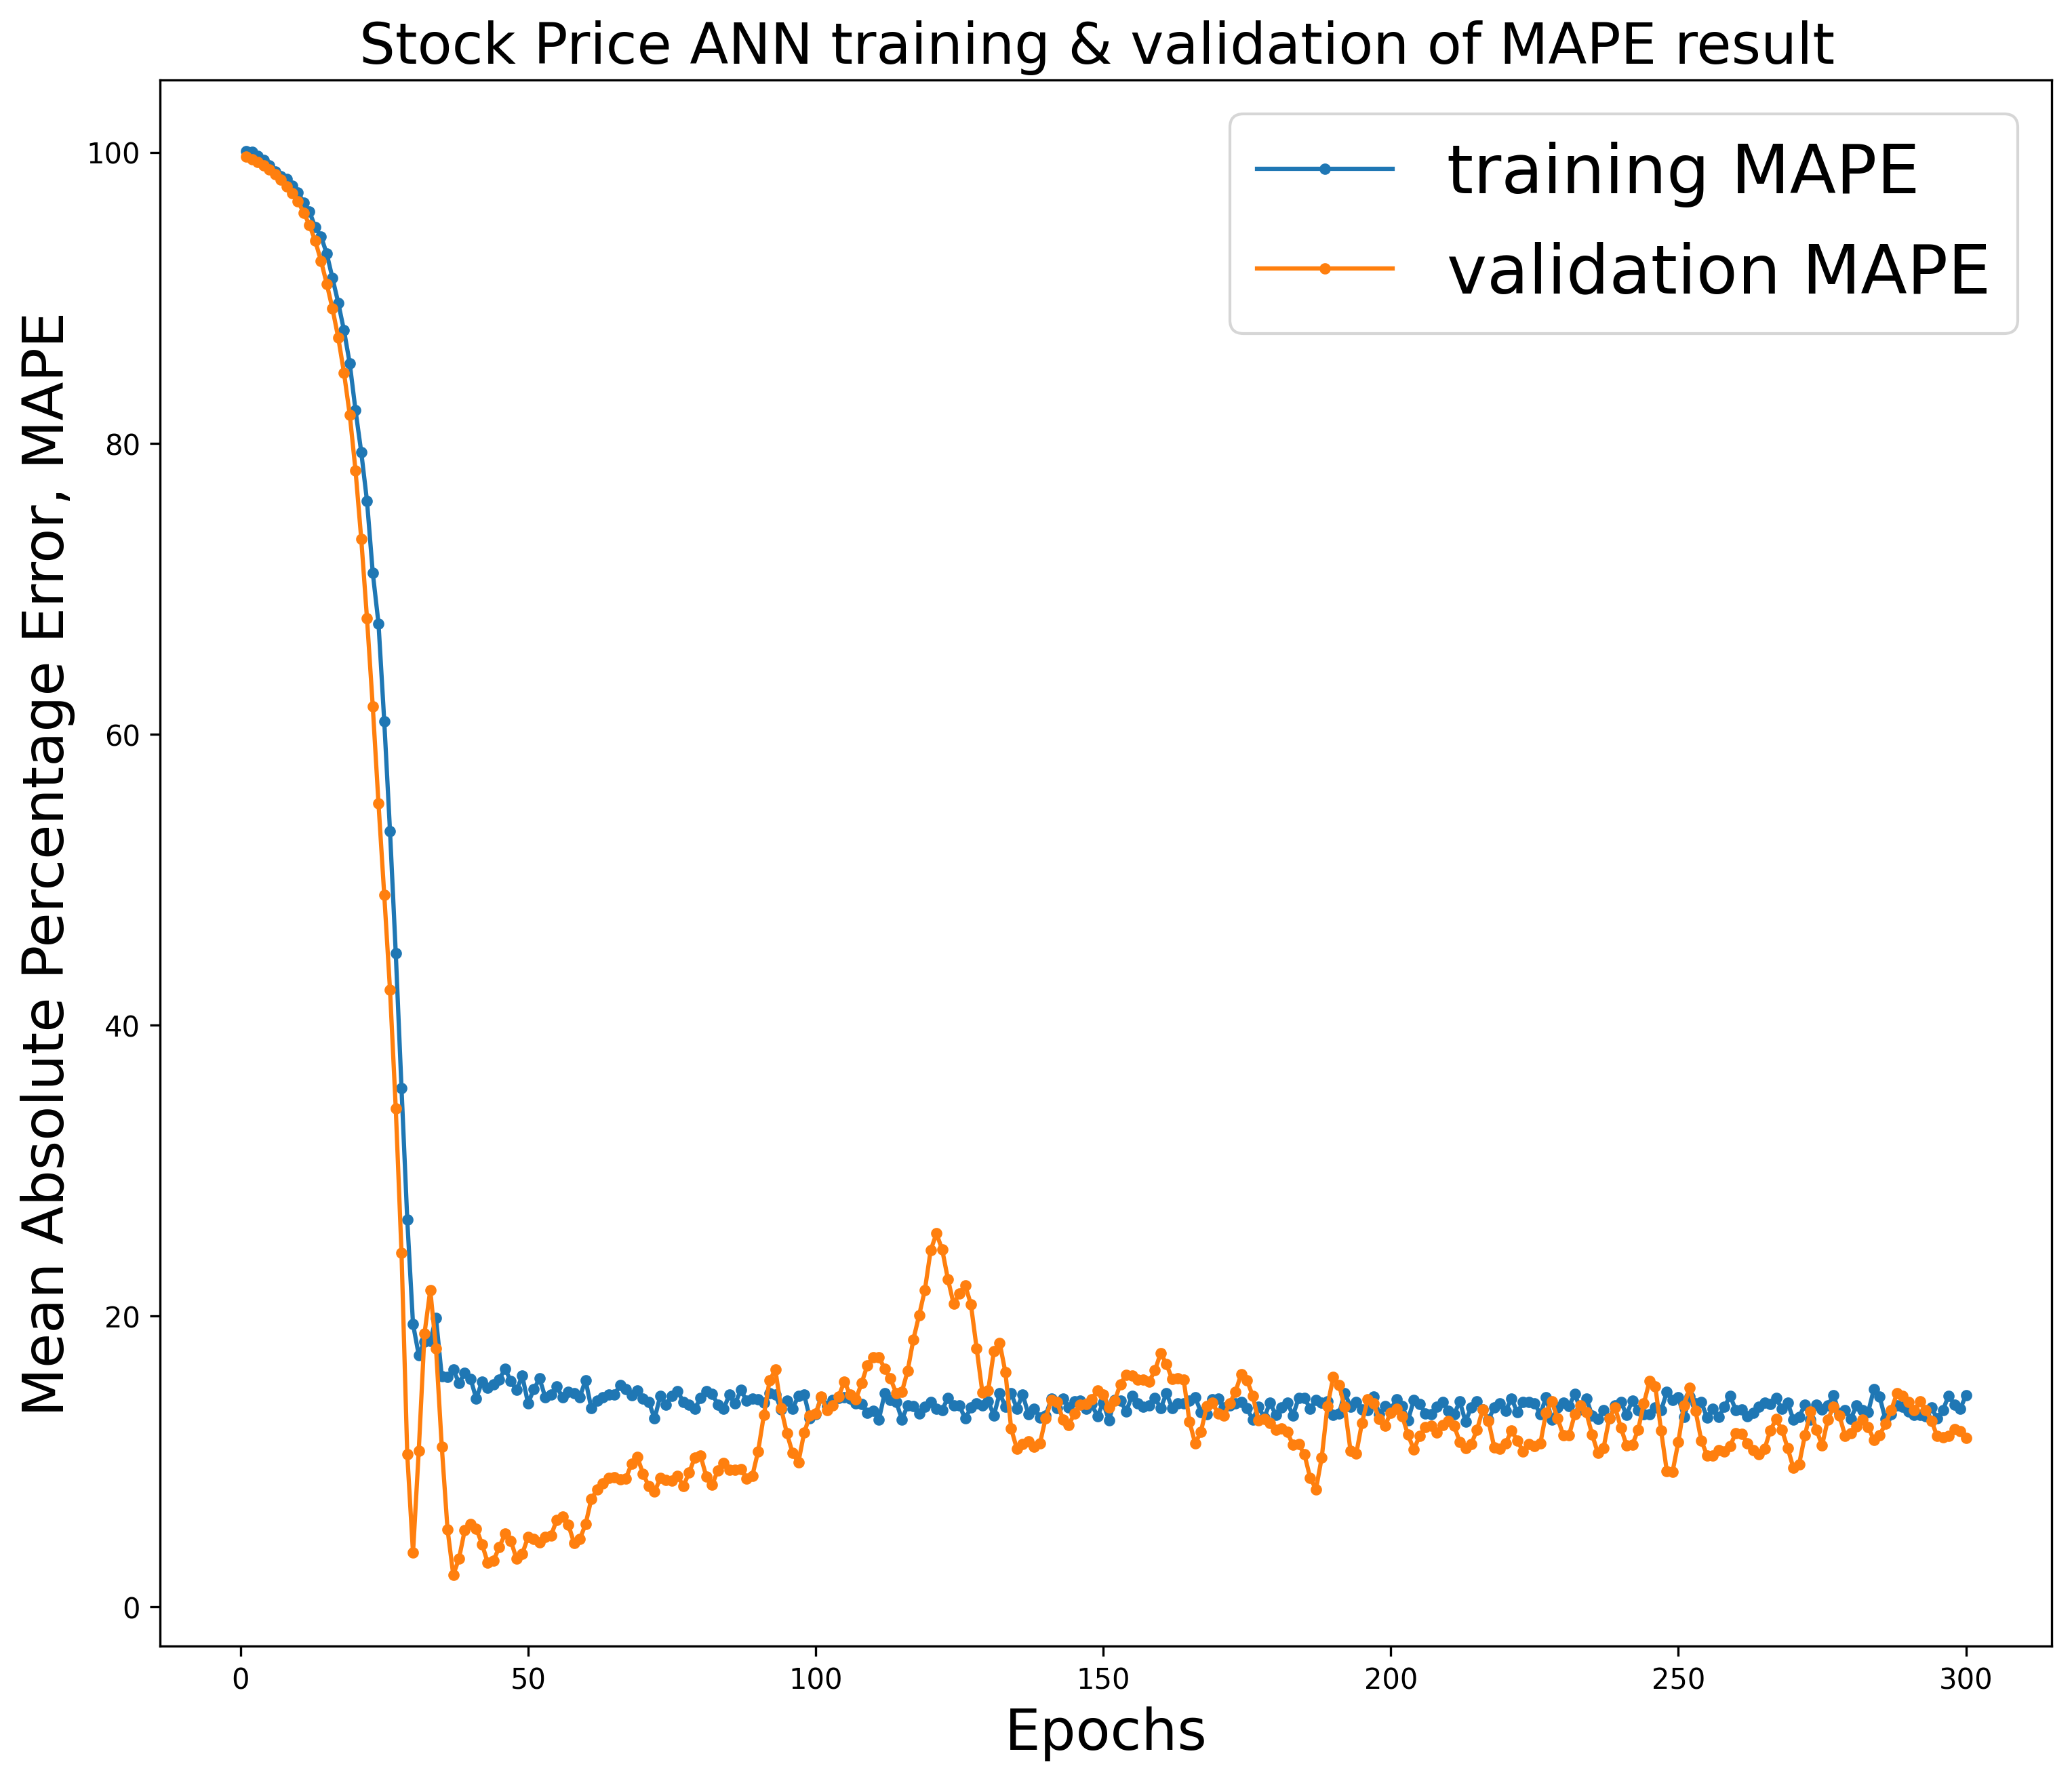

In [1544]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Stock Price ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [1612]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Adj Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Adj Close'].copy()

In [1626]:
# Create the model
clear.clear_session()
model=Sequential()

# Add input layer(有3個feature，所以input_dim=3) & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# Add 2 dense layers
dense_generator(model,3,2)

# Add dropout layer
model.add(Dropout(rate=0.3))

# Add 2 dense layers
dense_generator(model,3,2)

# regularization layer optional
model.add(BatchNormalization())

# Add 2 dense layers
dense_generator(model,3,2)

# Add dropout layer
model.add(Dropout(rate=0.3))

# Add output layer
model.add(Dense(units=1, activation='linear'))

# Compile the defined Net 改
opt=Adam(learning_rate=0.0008,beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 4)                 28        
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
 dense_5 (Dense)             (None, 8)                 4

In [1627]:
# Store in the history for more useful information
history=model.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
8/8 [==============================] - 2s 5ms/step - loss: 50.1213 - mean_absolute_percentage_error: 99.9708
Epoch 2/300
8/8 [==============================] - 0s 4ms/step - loss: 50.0602 - mean_absolute_percentage_error: 99.8881
Epoch 3/300
8/8 [==============================] - 0s 4ms/step - loss: 49.9907 - mean_absolute_percentage_error: 99.6996
Epoch 4/300
8/8 [==============================] - 0s 4ms/step - loss: 49.9354 - mean_absolute_percentage_error: 99.5951
Epoch 5/300
8/8 [==============================] - 0s 4ms/step - loss: 49.8498 - mean_absolute_percentage_error: 99.4171
Epoch 6/300
8/8 [==============================] - 0s 4ms/step - loss: 49.7585 - mean_absolute_percentage_error: 99.1903
Epoch 7/300
8/8 [==============================] - 0s 4ms/step - loss: 49.6187 - mean_absolute_percentage_error: 98.9518
Epoch 8/300
8/8 [==============================] - 0s 4ms/step - loss: 49.5015 - mean_absolute_percentage_error: 98.7521
Epoch 9/300
8/8 [===============

In [1628]:
# 7.3 Save the trained model
model.save('D:/data_analysis/PyExport/NVIDIAcorp_prediction_model')
# Colab
print('Model has been saved...')

Model has been saved...


In [1629]:
# 7.4 Restore the saved model for testing
DNN_model=keras.models.load_model('D:/data_analysis/PyExport/NVIDIAcorp_prediction_model')
# Colab
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [1630]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Adj Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Adj Close'].copy()

In [1631]:
DNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 4)                 28        
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
 dense_5 (Dense)             (None, 8)                 4

In [1632]:
# 8.1 Make prediction 
prediction=np.round((DNN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [1633]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Adj Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
450,2019-10-21,48.789135,45.009998,3.779137
451,2019-10-22,48.689564,44.459999,4.229565
452,2019-10-23,48.560135,44.950001,3.610134
453,2019-10-24,49.000694,45.180000,3.820694
454,2019-10-25,50.912342,45.060001,5.852341
...,...,...,...,...
747,2020-12-23,129.835495,96.230003,33.605492
748,2020-12-24,129.680801,96.279999,33.400802
749,2020-12-28,128.745132,94.889999,33.855133
750,2020-12-29,129.176773,94.360001,34.816772


In [1634]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)



print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 20.625
MSE: 588.257
RMSE: 24.254
MAPE: 20.365 %
SMAPE: 23.04 %
RAE: 0.723
MRAE: 0.002395131803468205
MdRAE: 0.847 bench: 91.061
RSE: 0.591
RRSE: 0.769


#  Plot for comparing true value & predicted value 

NameError: ignored

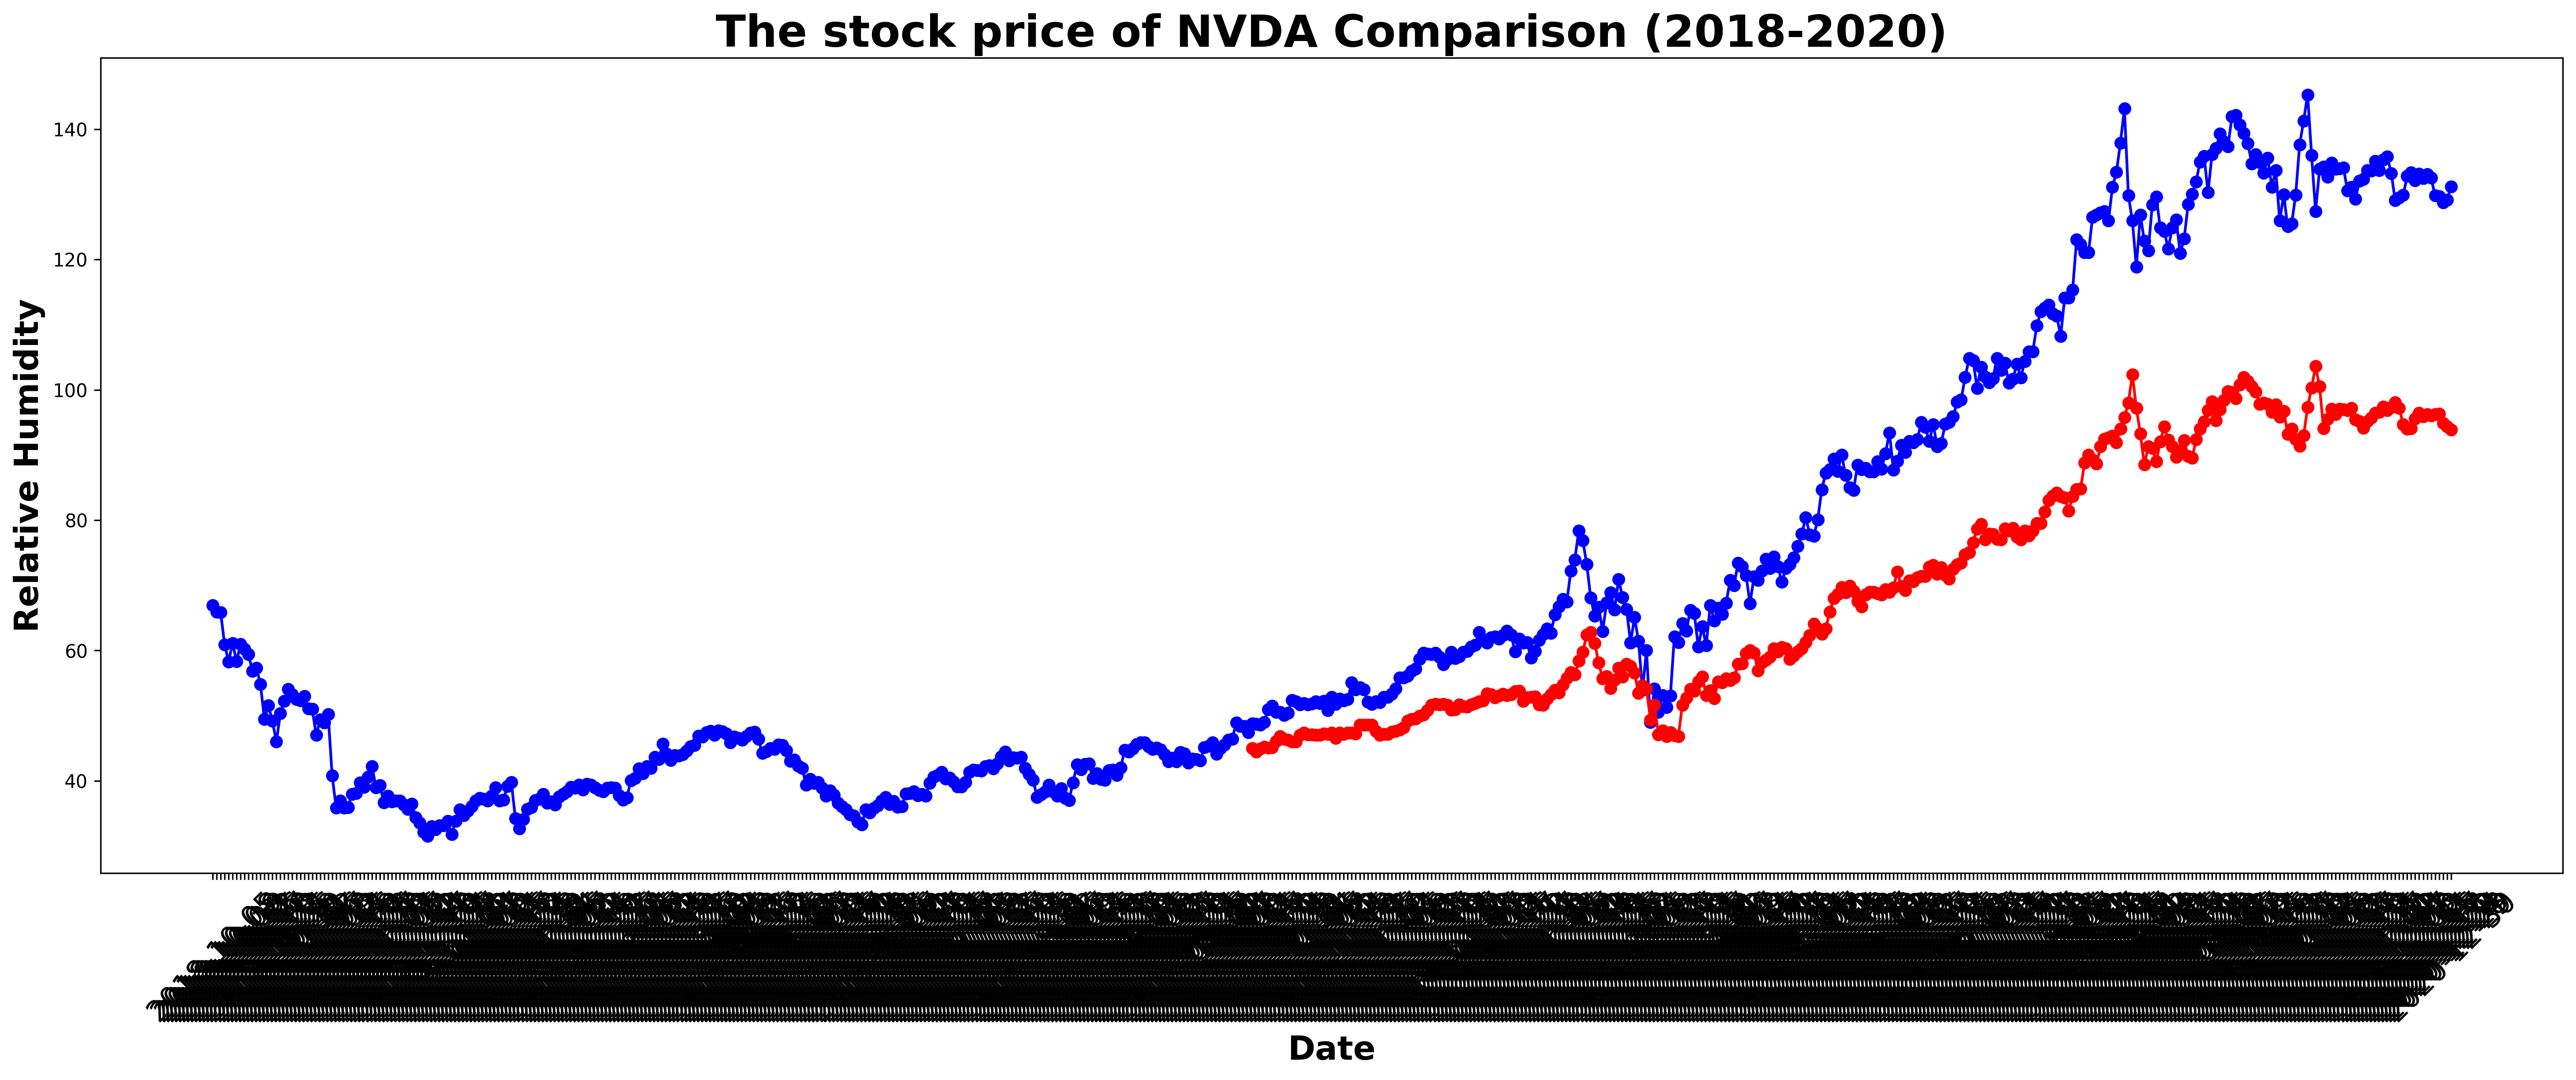

In [1635]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('The stock price of NVDA Comparison (2018-2020)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, len(clean_df.iloc[189:, 0]), step=step), clean_df.iloc[189::step, 0])
plt.yticks(fontsize=16)


# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

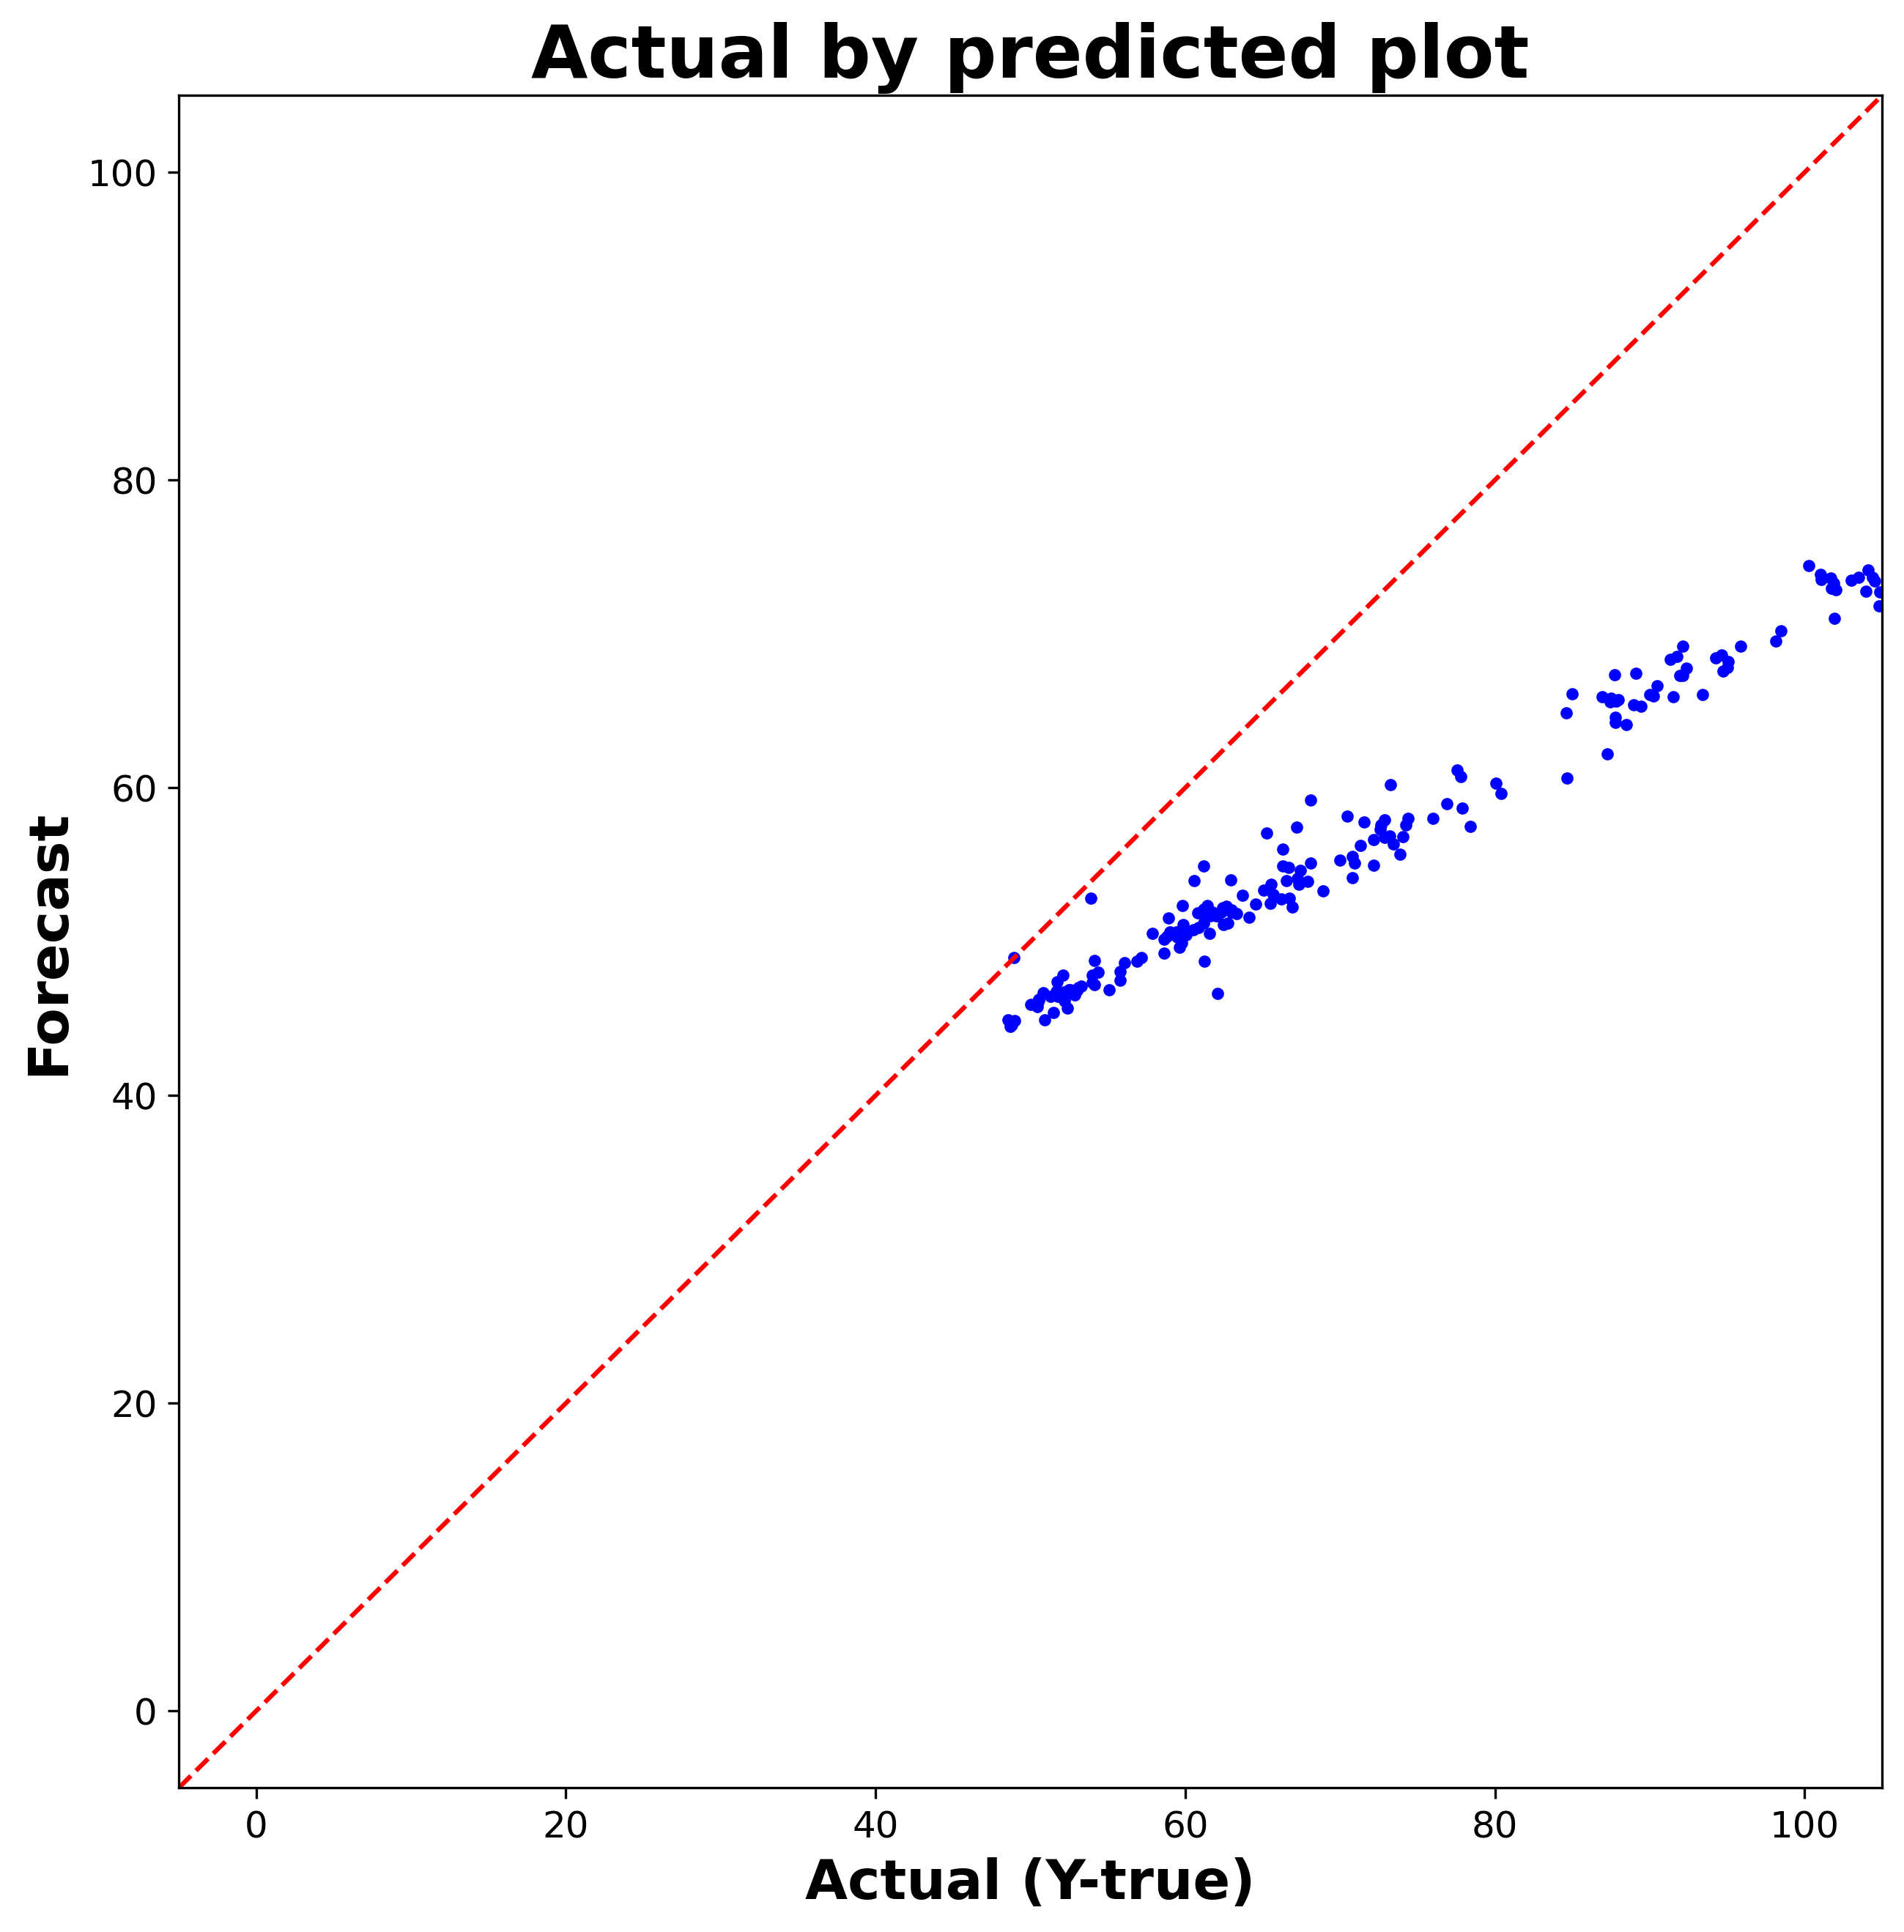

In [1623]:
# Lock the scale of axis by Y_true
max_value=100+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()